# Community Detection and Evaluation Using CDLIB

## 1. Import Libraries

In [1]:
import networkx as nx
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt
import igraph as ig

In [2]:
%matplotlib inline
random.seed(1)
plt.rcParams['figure.figsize'] = [50, 50]
import warnings
warnings.filterwarnings('ignore')
!pip install cdlib

  Using cached https://files.pythonhosted.org/packages/ce/eb/b97815c7454481d7ae3116e12ddbbad950ca7fef18f4eb0a89515e9b4e58/cdlib-0.1.7-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/04/66/ec5f1283d6a290a9153881a896837487338c44639c1305cc59e1c7b69cc9/scipy-1.3.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ea/de/8c82ad7acc647357bc76d6a90385cba7df8e57d99e25ca38e5e12178682f/matplotlib-3.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6b/be/608b7f72b851472388eafc010a5d46dae5d41610d0ac5df4c98c2ed1b865/numpy-1.16.4-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fc/43/fd867e3347559845c8f993059d410c50a1e18709f1c4d4b3b4732

    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


## 2. Load the graph into NetworkX and remove isolated nodes

In [3]:
graph = nx.read_graphml('../tvshows/output/YouNetflix.graphml')
nx.info(graph)

'Name: \nType: DiGraph\nNumber of nodes: 14660\nNumber of edges: 13932\nAverage in degree:   0.9503\nAverage out degree:   0.9503'

In [4]:
def remove_isolated_nodes(G):
    print(nx.info(G))
    isolated_nodes = list(nx.isolates(G))
    print('\nIsolated nodes: {}\n'.format(len(isolated_nodes)))
    print('removing isolated nodes...\n')
    G.remove_nodes_from(isolated_nodes)
    print(nx.info(G))
    return G

graph = remove_isolated_nodes(graph)

Name: 
Type: DiGraph
Number of nodes: 14660
Number of edges: 13932
Average in degree:   0.9503
Average out degree:   0.9503

Isolated nodes: 2065

removing isolated nodes...

Name: 
Type: DiGraph
Number of nodes: 12595
Number of edges: 13932
Average in degree:   1.1062
Average out degree:   1.1062


In [5]:
# Add weights to networkx graph
degree_list = ['retweet_count', 'mention_count', 'reply_count', 'quote_count']
attrs = {}
for (node1,node2,*data) in graph.edges(data=True):
    weight = sum([value for key, value in data[0].items() if key in degree_list])
    attrs[(node1, node2)] = {'weight': weight}
nx.set_edge_attributes(graph, attrs)

#nx.write_graphml(graph, 'strangerthings.graphml')

# 3. Apply CD algorithms using CDLib

In [6]:
from cdlib import algorithms, viz, evaluation, ensemble

### 3.1 Girvan Newman

In [7]:
undirected_graph = graph.to_undirected()
giant = graph.subgraph(max(list(nx.connected_components(undirected_graph)))).to_undirected()
pos = nx.spring_layout(graph)

In [8]:
girvan_newman_coms = algorithms.girvan_newman(graph, level=3)
# viz.plot_network_clusters(graph, girvan_newman_coms, pos)
# viz.plot_community_graph(graph, girvan_newman_coms)

KeyboardInterrupt: 

### 3.2 Greedy Modularity

In [9]:
greedy_mod_coms = algorithms.greedy_modularity(graph, weight)
# viz.plot_network_clusters(graph, greedy_mod_coms, pos)
# viz.plot_community_graph(graph, greedy_mod_coms)

IndexError: list index out of range

### 3.3 Info Map

In [10]:
infomap_coms = algorithms.infomap(graph)
# viz.plot_network_clusters(graph, infomap_coms, pos)
# viz.plot_community_graph(graph, infomap_coms)

ModuleNotFoundError: Optional dependency not satisfied: install infomap to use the selected feature.

### 3.4 Louvain

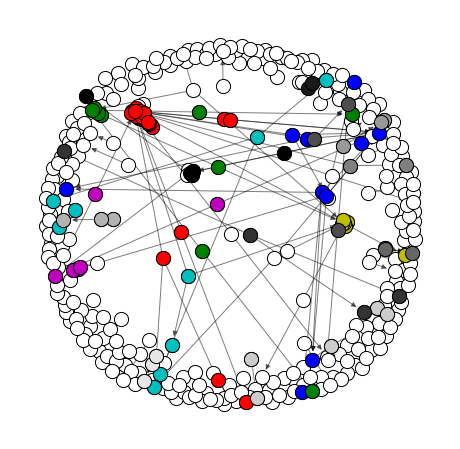

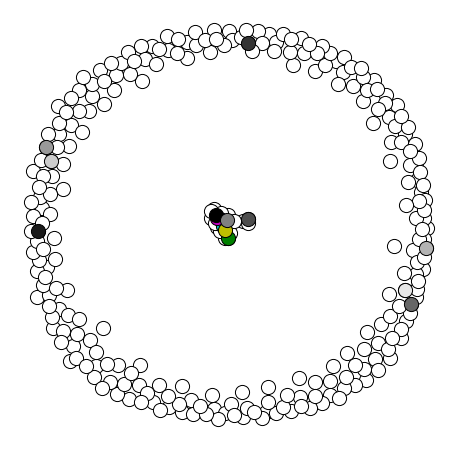

In [11]:
louvain_coms = algorithms.crisp_partition.louvain(undirected_graph, weight='weight', resolution=1., randomize=False)
# viz.plot_network_clusters(graph, louvain_coms, pos)
# viz.plot_community_graph(graph, louvain_coms)

### 3.5 Leiden

In [12]:
leiden_coms = algorithms.crisp_partition.leiden(undirected_graph)
viz.plot_network_clusters(graph, leiden_coms, pos)
viz.plot_community_graph(graph, leiden_coms)

ModuleNotFoundError: Optional dependency not satisfied: install igraph and leidenalg to use the selected feature.

### 3.6 WalkTrap

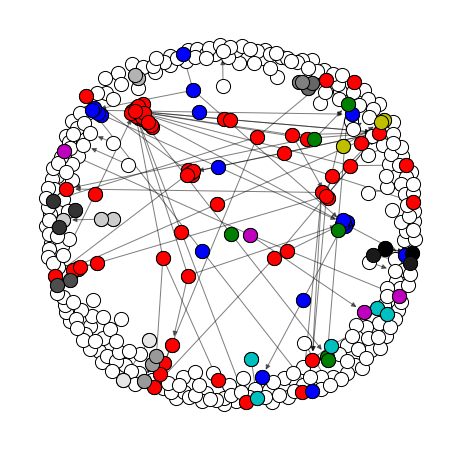

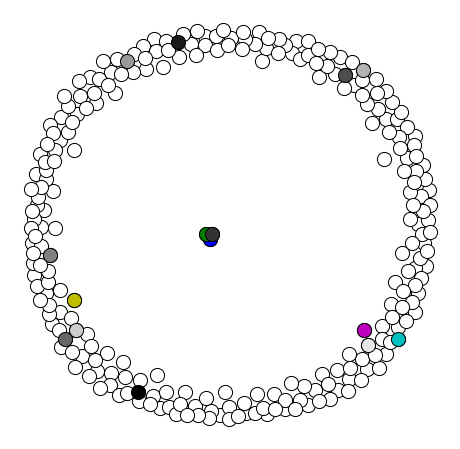

In [30]:
walktrap_coms = algorithms.walktrap(graph)
# viz.plot_network_clusters(graph, walktrap_coms, pos)
# viz.plot_community_graph(graph, walktrap_coms)

### 3.7 Leading Eigen Vector

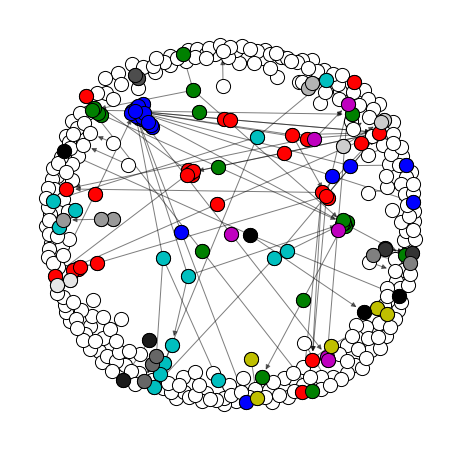

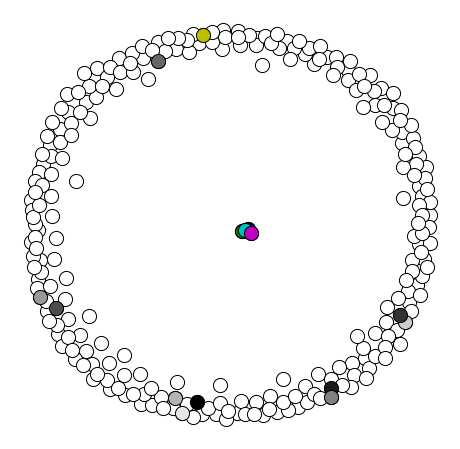

In [31]:
leading_eigen_coms = algorithms.eigenvector(graph)
viz.plot_network_clusters(graph, leading_eigen_coms, pos)
viz.plot_community_graph(graph, leading_eigen_coms)

### 3.8 Spin Glass

In [32]:
# spinglass_coms = algorithms.spinglass(giant)
# viz.plot_network_clusters(graph, spinglass_coms, pos)
# viz.plot_community_graph(graph, spinglass_coms)

### 3.9 SCAN

In [33]:
scan_coms = algorithms.scan(graph, epsilon=0.7, mu=3)
viz.plot_network_clusters(graph, scan_coms, pos)
viz.plot_community_graph(graph, scan_coms)

AttributeError: 'DiGraph' object has no attribute 'node'

## 4. Evaluation

In [34]:
resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize")
communities, scoring = ensemble.grid_search(graph=undirected_graph, method=algorithms.louvain,
                                                     parameters=[resolution, randomize],
                                                     quality_score=evaluation.erdos_renyi_modularity,
                                                     aggregate=max)
print(communities, scoring)

<cdlib.classes.node_clustering.NodeClustering object at 0x12f53d290> FitnessResult(min=None, max=None, score=0.9202909709512797, std=None)


In [35]:
resolution = ensemble.Parameter(name="resolution", start=0.1, end=1, step=0.1)
randomize = ensemble.BoolParameter(name="randomize")
louvain_conf = [resolution, randomize]

# Angel
threshold = ensemble.Parameter(name="threshold", start=0.1, end=1, step=0.1)
angel_conf = [threshold]
methods = [algorithms.louvain, algorithms.girvan_newman]
for communities, scoring in ensemble.pool_grid_filter(undirected_graph, methods, [louvain_conf, angel_conf], 
                                                      quality_score=evaluation.erdos_renyi_modularity, aggregate=max):
    print(communities, scoring)

<cdlib.classes.node_clustering.NodeClustering object at 0x12c6ff710> FitnessResult(min=None, max=None, score=0.9202909709512797, std=None)


TypeError: girvan_newman() got an unexpected keyword argument 'threshold'

In [36]:
evaluation.adjusted_mutual_information(graph, louvain_coms)

AttributeError: 'DiGraph' object has no attribute 'communities'

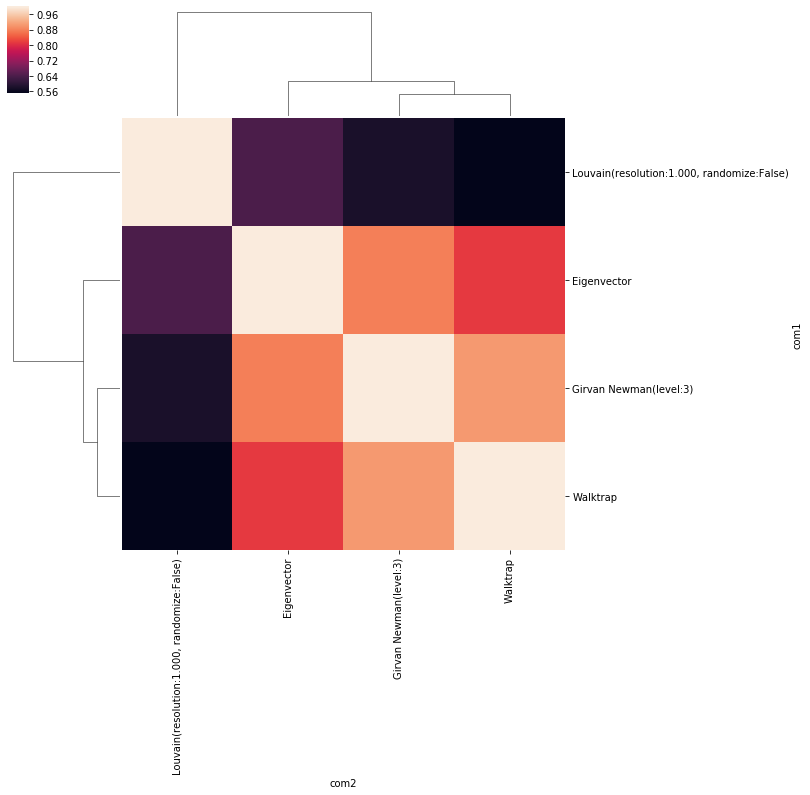

In [37]:
viz.plot_sim_matrix([girvan_newman_coms, louvain_coms, leading_eigen_coms, walktrap_coms], 
                    scoring=evaluation.adjusted_mutual_information)

In [38]:
evaluation.conductance(graph, girvan_newman_coms)

FitnessResult(min=0.0, max=0.11627906976744186, score=0.0007746969274245806, std=0.008149558391810743)

In [39]:
evaluation.adjusted_mutual_information(walktrap_coms, girvan_newman_coms)

MatchingResult(score=0.9073243560199257, std=None)

In [42]:
coms = [girvan_newman_coms, walktrap_coms, louvain_coms, leading_eigen_coms]


In [43]:
conductance = [evaluation.conductance(graph, com).score for com in coms]
conductance

[0.0007746969274245806,
 0.0003150404055009318,
 0.01766309119442226,
 0.0008488889446146402]

In [44]:
TPR = [evaluation.triangle_participation_ratio(undirected_graph, com).score for com in coms]
TPR

[0.0003616898148148148,
 0.00030048076923076925,
 0.001090909090909091,
 0.0006948304613674264]

In [45]:
modularity_density = [evaluation.modularity_density(graph, com).score for com in coms]
modularity_density

[479.2774629670214, 479.6411140614955, 492.2114184885604, 479.4706490747118]

In [46]:
significance = [evaluation.significance(graph, com).score for com in coms]
significance

[nan, nan, nan, nan]

In [49]:
surprise = [evaluation.surprise(graph, com).score for com in coms]
surprise

[1605.2597800217636,
 1509.4195988748388,
 1961.9204759901424,
 1810.5245594766006]

In [50]:
girvan_newman_modularity = [evaluation.newman_girvan_modularity(undirected_graph, com).score for com in coms]
girvan_newman_modularity

[0.9541075849301067, 0.947310907623618, 0.9822900670007062, 0.969325905134899]

In [51]:
eval_df = pd.DataFrame([conductance, TPR, modularity_density, girvan_newman_modularity, significance, surprise])

In [52]:
eval_df = eval_df.transpose()

In [53]:
eval_df.columns = ['Conductance', 'Triangle Participation Ratio', 'Modularity Density', 'Girvan Newman Modularity', 
                   'Significance', 'Surprise']

In [54]:
eval_df.index = ['Girvan Newman', 'Walktrap', 'Louvain', 'Leading Eigen']

In [55]:
eval_df

,Conductance,Triangle Participation Ratio,Modularity Density,Girvan Newman Modularity,Significance,Surprise
Girvan Newman,0.000775,0.000362,479.277463,0.954108,NaN,1605.259780
Walktrap,0.000315,0.000300,479.641114,0.947311,NaN,1509.419599
Louvain,0.017663,0.001091,492.211418,0.982290,NaN,1961.920476
Leading Eigen,0.000849,0.000695,479.470649,0.969326,NaN,1810.524559


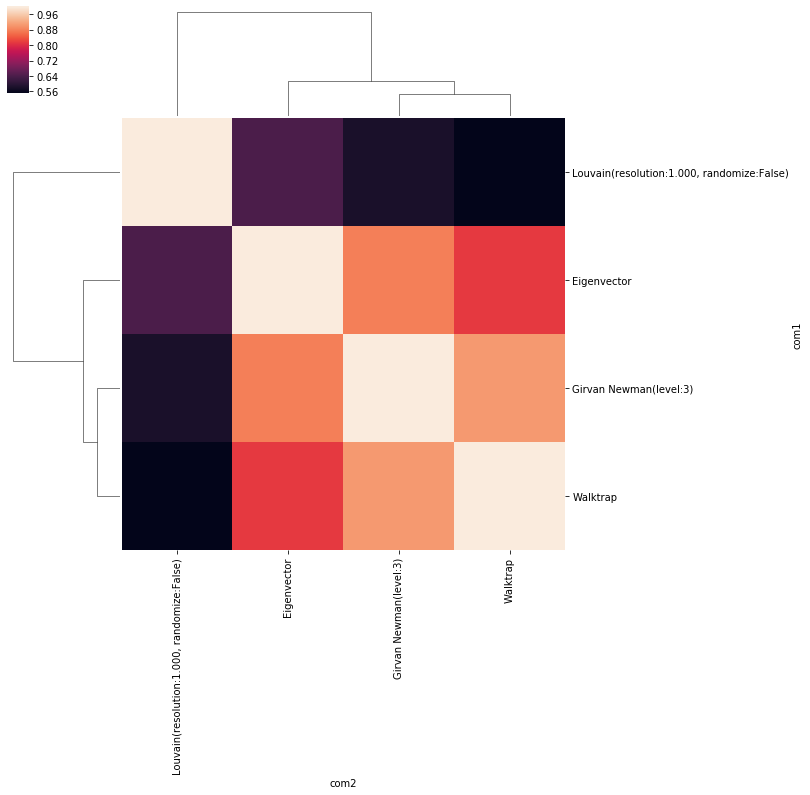

In [56]:
viz.plot_sim_matrix([girvan_newman_coms, louvain_coms, leading_eigen_coms, walktrap_coms], 
                    scoring=evaluation.adjusted_mutual_information)

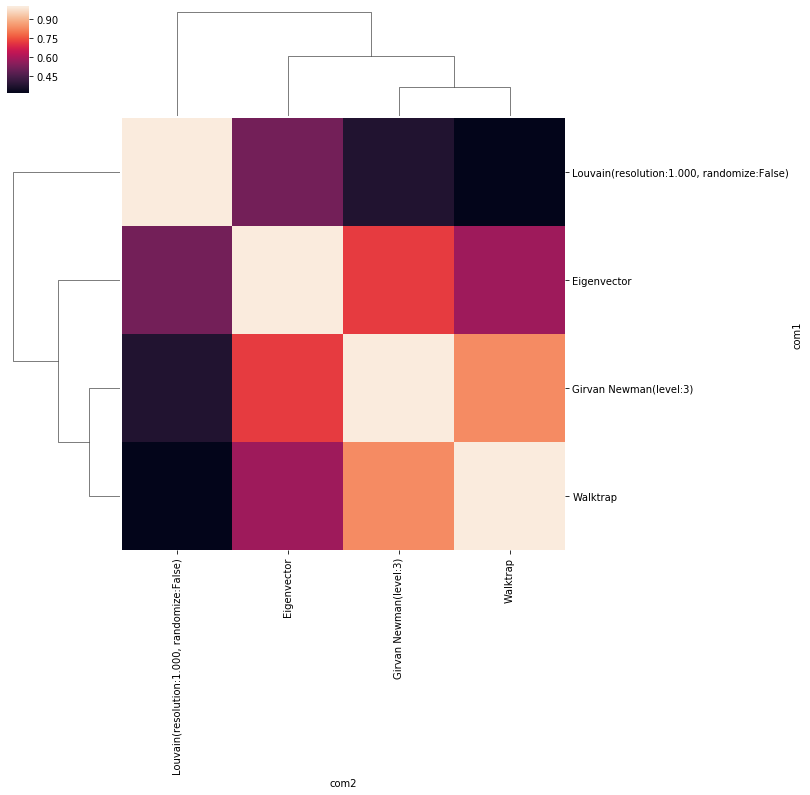

In [57]:
viz.plot_sim_matrix([girvan_newman_coms, louvain_coms, leading_eigen_coms, walktrap_coms], 
                    scoring=evaluation.adjusted_rand_index)